<a href="https://colab.research.google.com/github/GSP31/GSP31/blob/main/Keras_churn_pred_withOHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3 style='color:blue' align='center'>Customer Churn Prediction Using Deep Neural Network (DNN)</h3>

* Customer churn prediction is to measure why customers are leaving a business.

* In this tutorial we will be looking at customer churn in telecom business.

* We will build a deep learning model to predict the churn

In [ ]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
#STEP-2: Autheticate E-Mail ID

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#STEP-3: Get File from Drive using file-ID

#2.1 Get the file
downloaded = drive.CreateFile({'id':'1U-9tZd1k-MisO8LIRyl-1sX5T7_xO7rg'}) # replace the id with id of file you want to access
downloaded.GetContentFile('customer_churn.csv')

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score

### Load the data

In [ ]:
df = pd.read_csv("customer_churn.csv")
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4646,5032-MIYKT,Female,0,No,No,1,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,70.70,70.7,No
5824,5321-NTRKC,Male,0,Yes,Yes,66,Yes,Yes,DSL,No,...,Yes,No,Yes,Yes,Two year,No,Bank transfer (automatic),79.85,5234.95,No
1907,2272-UOINI,Female,0,No,No,7,Yes,No,DSL,Yes,...,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,78.50,571.05,No
2920,9453-PATOS,Female,0,Yes,No,72,Yes,No,DSL,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Mailed check,85.10,6155.4,No
6472,1150-FTQGN,Female,0,Yes,Yes,60,Yes,Yes,Fiber optic,Yes,...,No,No,Yes,No,One year,No,Bank transfer (automatic),94.15,5811.8,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


* Drop customerID

In [ ]:
df.drop('customerID',axis='columns',inplace=True)

In [ ]:
df.shape

(7043, 20)

In [ ]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

* TotalCharges should be float but it is an object

In [ ]:
df.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

**It is string. Lets convert it to numbers**

In [ ]:
#error due some space between numbers ""
#pd.to_numeric(df.TotalCharges)

**Some values seems to be not numbers but blank string**

* coerce shows TRUE for blank spaces and replaces with Null

In [ ]:
pd.to_numeric(df.TotalCharges,errors='coerce').isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: TotalCharges, Length: 7043, dtype: bool

## Check blank spaces in 'TotalCharges' feature

In [ ]:
df[pd.to_numeric(df.TotalCharges,errors='coerce').isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [ ]:
df.iloc[488].TotalCharges

' '

In [ ]:
df[df.TotalCharges!=' '].shape

(7032, 20)

**Remove rows with space in TotalCharges**

In [ ]:
df1 = df[df.TotalCharges!=' ']
df1.shape

(7032, 20)

In [ ]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

In [ ]:
df1.TotalCharges.values

array([  29.85, 1889.5 ,  108.15, ...,  346.45,  306.6 , 6844.5 ])

In [ ]:
df1.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

## Customers who are not leaving

* Also check their tenure in one feature

In [ ]:
df1[df1.Churn=='No']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,Female,0,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,No
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No


## Check their tenure

In [ ]:
df1[df1.Churn=='No'].tenure

0        1
1       34
3       45
6       22
7       10
        ..
7037    72
7038    24
7039    72
7040    11
7042    66
Name: tenure, Length: 5163, dtype: int64

# EDA

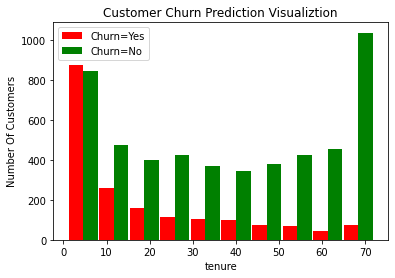

In [ ]:
tenure_churn_no = df1[df1.Churn=='No'].tenure
tenure_churn_yes = df1[df1.Churn=='Yes'].tenure

plt.xlabel("tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['red','green'],label=['Churn=Yes','Churn=No'])
plt.legend()

* Monthly charges, customers might leave

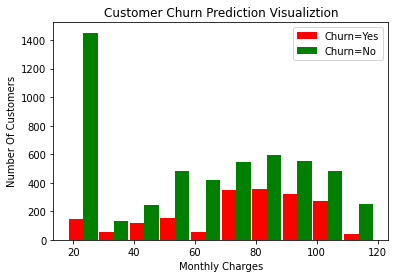

In [ ]:
mc_churn_no = df1[df1.Churn=='No'].MonthlyCharges
mc_churn_yes = df1[df1.Churn=='Yes'].MonthlyCharges

plt.xlabel("Monthly Charges")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([mc_churn_yes, mc_churn_no], rwidth=0.95, color=['red','green'],label=['Churn=Yes','Churn=No'])
plt.legend()

* Many features are 'yes', 'no' etc.

* Print unique values in object columns to see data values

In [ ]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}')

In [ ]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


## Some features have no internet service or no phone service, that can be replaced with a simple No

In [ ]:
df1.replace('No internet service','No',inplace=True)
df1.replace('No phone service','No',inplace=True)

In [ ]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


## Convert Yes and No to 1 or 0

In [ ]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df1[col].replace({'Yes': 1,'No': 0},inplace=True)

In [ ]:
for col in df1:
    print(f'{col}: {df1[col].unique()}')

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


In [ ]:
df1['gender'].replace({'Female':1,'Male':0},inplace=True)

In [ ]:
df1.gender.unique()

array([1, 0])

 # One hot encoding for categorical features

In [ ]:
df2 = pd.get_dummies(data=df1, columns=['InternetService','Contract','PaymentMethod'])
df2.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [ ]:
df2.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5068,1,0,1,0,71,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
2436,1,1,0,0,31,1,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
2145,0,0,0,0,11,1,0,0,0,1,...,0,1,0,1,0,0,0,0,1,0
2418,1,1,0,0,27,1,1,0,1,1,...,0,1,0,1,0,0,1,0,0,0
4701,0,1,0,0,21,1,1,0,1,1,...,0,1,0,1,0,0,0,0,1,0


In [ ]:
df2.shape

(7032, 27)

In [ ]:
df2.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No             

## Scale

In [ ]:
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df2[cols_to_scale] = scaler.fit_transform(df2[cols_to_scale])

In [ ]:
for col in df2:
    print(f'{col}: {df2[col].unique()}')

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

In [ ]:
X = df2.drop('Churn',axis='columns')
y = df2['Churn']



## One hot encode outputs

In [ ]:
y = to_categorical(y)

In [ ]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

# Train test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [ ]:
X_train.shape

(5625, 26)

In [ ]:
X_test.shape

(1407, 26)

In [ ]:
X_train[:10]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5664,1,1,0,0,0.126761,1,0,0,0,1,...,0,1,0,1,0,0,0,1,0,0
101,1,0,1,1,0.000000,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
2621,0,0,1,0,0.985915,1,0,0,1,1,...,1,0,0,0,0,1,0,1,0,0
392,1,1,0,0,0.014085,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
1327,0,0,1,0,0.816901,1,1,0,0,1,...,0,1,0,0,1,0,1,0,0,0
3607,1,0,0,0,0.169014,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
2773,0,0,1,0,0.323944,0,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0
1936,1,0,1,0,0.704225,1,0,1,1,0,...,1,0,0,0,1,0,1,0,0,0
5387,0,0,0,0,0.042254,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
4331,0,0,0,0,0.985915,1,1,0,0,0,...,0,0,1,0,0,1,1,0,0,0


In [ ]:
len(X_train.columns)

26

# Build a model (DNN) in tensorflow/keras

In [ ]:
import tensorflow as tf
from tensorflow import keras


model = keras.Sequential([
    keras.layers.Dense(26, input_shape=(26,), activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])


## Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 26)                702       
                                                                 
 dense_1 (Dense)             (None, 20)                540       
                                                                 
 dense_2 (Dense)             (None, 15)                315       
                                                                 
 dense_3 (Dense)             (None, 2)                 32        
                                                                 
Total params: 1,589
Trainable params: 1,589
Non-trainable params: 0
_________________________________________________________________


## Compile model

In [ ]:
# opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit the model

In [ ]:
history = model.fit(X_train, y_train, epochs=50)

Epoch 1/50
176/176 [==============================] - 9s 5ms/step - loss: 0.5275 - accuracy: 0.7339
Epoch 2/50
176/176 [==============================] - 1s 5ms/step - loss: 0.4305 - accuracy: 0.7902
Epoch 3/50
176/176 [==============================] - 1s 5ms/step - loss: 0.4192 - accuracy: 0.7993
Epoch 4/50
176/176 [==============================] - 1s 6ms/step - loss: 0.4147 - accuracy: 0.8009
Epoch 5/50
176/176 [==============================] - 1s 6ms/step - loss: 0.4127 - accuracy: 0.8064
Epoch 6/50
176/176 [==============================] - 1s 6ms/step - loss: 0.4104 - accuracy: 0.8084
Epoch 7/50
176/176 [==============================] - 1s 5ms/step - loss: 0.4063 - accuracy: 0.8128
Epoch 8/50
176/176 [==============================] - 1s 5ms/step - loss: 0.4042 - accuracy: 0.8124
Epoch 9/50
176/176 [==============================] - 2s 9ms/step - loss: 0.4020 - accuracy: 0.8164
Epoch 10/50
176/176 [==============================] - 1s 7ms/step - loss: 0.4001 - accuracy: 0.8135

In [ ]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 0s 3ms/step - loss: 0.5059 - accuracy: 0.7704


[0.5058730244636536, 0.7704335451126099]

In [ ]:
yp = model.predict(X_test)
yp[:5]

44/44 [==============================] - 0s 2ms/step


array([[0.62873256, 0.37126747],
       [0.6474377 , 0.35256228],
       [0.9976234 , 0.00237659],
       [0.30020759, 0.69979244],
       [0.36372483, 0.6362752 ]], dtype=float32)

In [ ]:
#pred_train= model.predict(X_train)
#scores = model.evaluate(X_train, y_train, verbose=0)
#print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))

pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))

44/44 [==============================] - 0s 2ms/step
Accuracy on test data: 0.7704335451126099% 
 Error on test data: 0.22956645488739014


In [ ]:
pred_test[:5]

array([[0.62873256, 0.37126747],
       [0.6474377 , 0.35256228],
       [0.9976234 , 0.00237659],
       [0.30020759, 0.69979244],
       [0.36372483, 0.6362752 ]], dtype=float32)

In [ ]:
Y_pred_classes = np.argmax(pred_test,axis = 1)

print(Y_pred_classes)
print('*************************************')
Y_true = np.argmax(y_test,axis = 1)
print(Y_true)



[0 0 0 ... 1 1 1]
*************************************
[0 0 1 ... 1 0 1]


##Compute the confusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
cm

array([[849, 150],
       [173, 235]])

In [ ]:
y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

ValueError: ignored

In [ ]:
y_pred[:10]

In [ ]:
y_test[:10]

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_test,y_pred))

In [ ]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Exercise

* Re-configure DNN
   
* Use Sofmax instead of sigmoid
* SMOTE (initially)

* Check if model is overfit

* Use dropout layer(s) and improve the model